In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from keras.losses import mean_squared_error

In [2]:
class WildfireAutoencoder:
    def __init__(self, img_size=64, latent_dim=32):
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.encoder = None
        self.decoder = None
        self.autoencoder = None
        self.classifier = None
        self.history = None
        self.class_names = ['nowildfire', 'wildfire']
        
    def load_and_preprocess_data(self, train_dir, valid_dir, test_dir):
        """Load and preprocess images from directories"""
        def load_data_from_dir(directory):
            x_data = []
            y_data = []
            for class_name in os.listdir(directory):
                class_dir = os.path.join(directory, class_name)
                class_label = 1 if class_name == 'wildfire' else 0
                for filename in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, filename)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (self.img_size, self.img_size))
                    img = img / 255.0  # Normalize
                    x_data.append(img)
                    y_data.append(class_label)
            return np.array(x_data), np.array(y_data)

        print("Loading training data...")
        self.x_train, self.y_train = load_data_from_dir(train_dir)
        print("Loading validation data...")
        self.x_val, self.y_val = load_data_from_dir(valid_dir)
        print("Loading test data...")
        self.x_test, self.y_test = load_data_from_dir(test_dir)

        # Compute class weights for classifier
        self.class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        self.class_weight_dict = dict(enumerate(self.class_weights))
        
        # Save the processed data to disk
        self.save_processed_data("preprocessed_data")
        
    def save_processed_data(self, directory):
        """Save preprocessed data to disk"""
        os.makedirs(directory, exist_ok=True)
        np.save(os.path.join(directory, 'x_train.npy'), self.x_train)
        np.save(os.path.join(directory, 'y_train.npy'), self.y_train)
        np.save(os.path.join(directory, 'x_val.npy'), self.x_val)
        np.save(os.path.join(directory, 'y_val.npy'), self.y_val)
        np.save(os.path.join(directory, 'x_test.npy'), self.x_test)
        np.save(os.path.join(directory, 'y_test.npy'), self.y_test)
        np.save(os.path.join(directory, 'class_weights.npy'), self.class_weights)
        print(f"Preprocessed data saved to {directory}")
        
    def load_processed_data(self, directory):
        """Load preprocessed data from disk"""
        self.x_train = np.load(os.path.join(directory, 'x_train.npy'))
        self.y_train = np.load(os.path.join(directory, 'y_train.npy'))
        self.x_val = np.load(os.path.join(directory, 'x_val.npy'))
        self.y_val = np.load(os.path.join(directory, 'y_val.npy'))
        self.x_test = np.load(os.path.join(directory, 'x_test.npy'))
        self.y_test = np.load(os.path.join(directory, 'y_test.npy'))
        self.class_weights = np.load(os.path.join(directory, 'class_weights.npy'))
        self.class_weight_dict = dict(enumerate(self.class_weights))
        print(f"Preprocessed data loaded from {directory}")

    def build_autoencoder(self):
        """Build encoder, decoder and autoencoder models"""
        # Create data augmentation layer
        data_augmentation = Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.2),
            RandomZoom(0.2),
        ])
        
        # Define encoder
        input_img = Input(shape=(self.img_size, self.img_size, 3))
        augmented = data_augmentation(input_img)
        
        # Encoder path
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(augmented)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        
        # Calculate shape before flatten
        shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
        
        # Latent space representation
        x = Flatten()(x)
        encoded = Dense(self.latent_dim, activation='relu')(x)
        
        # Create encoder model
        self.encoder = Model(input_img, encoded, name='encoder')
        
        # Define decoder
        latent_input = Input(shape=(self.latent_dim,))
        x = Dense(np.prod(shape_before_flatten), activation='relu')(latent_input)
        x = Reshape(shape_before_flatten)(x)
        
        # Decoder path
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        
        # Create decoder model
        self.decoder = Model(latent_input, decoded, name='decoder')
        
        # Create autoencoder model
        self.autoencoder = Model(input_img, self.decoder(self.encoder(input_img)), name='autoencoder')
        
        # Compile autoencoder
        self.autoencoder.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mean_squared_error'  # Using full name instead of 'mse' for better compatibility
        )
        
        return self.autoencoder
    
    def build_classifier(self):
        """Build classifier model on top of the encoder"""
        # Freeze the encoder layers
        self.encoder.trainable = False
        
        # Create classification head
        latent_input = Input(shape=(self.latent_dim,))
        x = Dense(64, activation='relu')(latent_input)
        x = Dropout(0.5)(x)
        output = Dense(1, activation='sigmoid')(x)
        
        # Create classifier model
        classification_head = Model(latent_input, output, name='classification_head')
        
        # Connect encoder to classification head
        input_img = Input(shape=(self.img_size, self.img_size, 3))
        encoded_features = self.encoder(input_img)
        predictions = classification_head(encoded_features)
        
        # Full classifier model
        self.classifier = Model(input_img, predictions, name='classifier')
        
        # Compile classifier
        self.classifier.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return self.classifier

    def train_autoencoder(self, epochs=50, batch_size=32):
        """Train the autoencoder model"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
        ]
        
        self.autoencoder_history = self.autoencoder.fit(
            self.x_train, self.x_train,  # Input equals target for autoencoder
            validation_data=(self.x_val, self.x_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )
    
    def train_classifier(self, epochs=50, batch_size=32):
        """Train the classifier model"""
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            )
        ]
        
        self.classifier_history = self.classifier.fit(
            self.x_train, self.y_train,
            validation_data=(self.x_val, self.y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=self.class_weight_dict,
            callbacks=callbacks
        )

    def evaluate_autoencoder(self):
        """Evaluate the autoencoder and visualize reconstructions"""
        # Get reconstructions
        reconstructions = self.autoencoder.predict(self.x_test[:10])
        
        # Plot original vs reconstructed images
        plt.figure(figsize=(20, 4))
        for i in range(10):
            # Original
            plt.subplot(2, 10, i + 1)
            plt.imshow(self.x_test[i])
            plt.title(f"Original: {self.class_names[self.y_test[i]]}")
            plt.axis('off')
            
            # Reconstruction
            plt.subplot(2, 10, i + 11)
            plt.imshow(reconstructions[i])
            plt.title("Reconstructed")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()
        
    def evaluate_classifier(self):
        """Evaluate the classifier model"""
        # Test set evaluation
        test_loss, test_accuracy = self.classifier.evaluate(self.x_test, self.y_test)
        print(f'\nTest Accuracy: {test_accuracy:.4f}')

        # Get predictions
        y_pred = self.classifier.predict(self.x_test)
        y_pred_classes = (y_pred > 0.5).astype(int)

        # Display confusion matrix
        cm = confusion_matrix(self.y_test, y_pred_classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Display classification report
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred_classes))
    
    def plot_latent_space(self, n=10):
        """Plot samples from latent space"""
        # Display a grid of generated images
        figure = plt.figure(figsize=(10, 10))
        
        # Generate random samples in latent space
        latent_samples = np.random.normal(size=(n*n, self.latent_dim))
        
        # Decode them to images
        generated_images = self.decoder.predict(latent_samples)
        
        # Plot them
        for i in range(n*n):
            plt.subplot(n, n, i+1)
            plt.imshow(generated_images[i])
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()
        
    def plot_training_history(self, model_type='autoencoder'):
        """Plot training history"""
        history = self.autoencoder_history if model_type == 'autoencoder' else self.classifier_history
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        ax1.plot(history.history['loss'], label='Training')
        ax1.plot(history.history['val_loss'], label='Validation')
        ax1.set_title(f'{model_type.capitalize()} Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        # For classifier, also plot accuracy
        if model_type == 'classifier':
            ax2.plot(history.history['accuracy'], label='Training')
            ax2.plot(history.history['val_accuracy'], label='Validation')
            ax2.set_title('Classifier Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.legend()
        else:
            ax2.axis('off')

        plt.tight_layout()
        plt.show()

    def save_models(self, directory):
        """Save all models"""
        os.makedirs(directory, exist_ok=True)
        
        if self.encoder:
            self.encoder.save(os.path.join(directory, 'encoder.h5'))
        
        if self.decoder:
            self.decoder.save(os.path.join(directory, 'decoder.h5'))
        
        if self.autoencoder:
            self.autoencoder.save(os.path.join(directory, 'autoencoder.h5'))
        
        if self.classifier:
            self.classifier.save(os.path.join(directory, 'classifier.h5'))
            
        print(f"Models saved to {directory}")

    def load_models(self, directory):
        """Load all models"""
        # Define custom objects for model loading
        custom_objects = {'mse': mean_squared_error}
        
        encoder_path = os.path.join(directory, 'encoder.h5')
        decoder_path = os.path.join(directory, 'decoder.h5')
        autoencoder_path = os.path.join(directory, 'autoencoder.h5')
        classifier_path = os.path.join(directory, 'classifier.h5')
        
        if os.path.exists(encoder_path):
            self.encoder = load_model(encoder_path, custom_objects=custom_objects)
            print("Encoder model loaded")
            
        if os.path.exists(decoder_path):
            self.decoder = load_model(decoder_path, custom_objects=custom_objects)
            print("Decoder model loaded")
            
        if os.path.exists(autoencoder_path):
            self.autoencoder = load_model(autoencoder_path, custom_objects=custom_objects)
            print("Autoencoder model loaded")
            
        if os.path.exists(classifier_path):
            self.classifier = load_model(classifier_path, custom_objects=custom_objects)
            print("Classifier model loaded")

    def predict_single_image(self, image_path):
        """Predict whether a single image contains a wildfire"""
        # Load and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.resize(img, (self.img_size, self.img_size))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Make prediction using the classifier
        prediction = self.classifier.predict(img)[0][0]
        predicted_class = 'Wildfire' if prediction > 0.5 else 'No Wildfire'
        confidence = prediction if prediction > 0.5 else 1 - prediction
        
        # Generate reconstruction
        reconstruction = self.autoencoder.predict(img)[0]
        
        # Calculate reconstruction error (can be used for anomaly detection)
        mse = np.mean(np.square(img[0] - reconstruction))

        return {
            'class': predicted_class,
            'confidence': float(confidence),
            'raw_prediction': float(prediction),
            'reconstruction_error': float(mse),
            'reconstruction': reconstruction
        }

    def detect_anomalies(self, images, threshold=None):
        """Detect anomalies using reconstruction error"""
        if threshold is None:
            # Calculate threshold from training data
            recon_errors = []
            batch_size = 32
            for i in range(0, len(self.x_train), batch_size):
                batch = self.x_train[i:i+batch_size]
                recons = self.autoencoder.predict(batch)
                for j in range(len(batch)):
                    recon_errors.append(np.mean(np.square(batch[j] - recons[j])))
            
            # Set threshold as mean + 2*std of training reconstruction errors
            threshold = np.mean(recon_errors) + 2 * np.std(recon_errors)
            
        # Predict on new images
        reconstructions = self.autoencoder.predict(images)
        anomalies = []
        
        for i in range(len(images)):
            error = np.mean(np.square(images[i] - reconstructions[i]))
            anomalies.append({
                'index': i,
                'reconstruction_error': float(error),
                'is_anomaly': error > threshold
            })
            
        return anomalies, threshold

In [3]:
img_size = 64  # Size to resize images to
latent_dim = 32  # Size of latent space dimension

# Create model instance
model = WildfireAutoencoder(img_size=img_size, latent_dim=latent_dim)

In [4]:
# Update these paths to your data directories
train_dir = r'C:\Users\shash\Downloads\archive\valid'
valid_dir = r'C:\Users\shash\Downloads\archive\train'
test_dir = r'C:\Users\shash\Downloads\archive\test' 

# Load and preprocess data (this will also save the processed data to disk)
model.load_and_preprocess_data(train_dir, valid_dir, test_dir)

Loading training data...
Loading validation data...
Loading test data...
Preprocessed data saved to preprocessed_data


In [5]:
print(f"Training data shape: {model.x_train.shape}, Labels: {model.y_train.shape}")
print(f"Validation data shape: {model.x_val.shape}, Labels: {model.y_val.shape}")
print(f"Test data shape: {model.x_test.shape}, Labels: {model.y_test.shape}")

Training data shape: (6300, 64, 64, 3), Labels: (6300,)
Validation data shape: (30250, 64, 64, 3), Labels: (30250,)
Test data shape: (6300, 64, 64, 3), Labels: (6300,)


In [6]:
train_wildfire = np.sum(model.y_train)
train_total = len(model.y_train)
print(f"Training class distribution: Wildfire: {train_wildfire} ({100*train_wildfire/train_total:.2f}%), No Wildfire: {train_total-train_wildfire} ({100*(train_total-train_wildfire)/train_total:.2f}%)")

Training class distribution: Wildfire: 3480 (55.24%), No Wildfire: 2820 (44.76%)


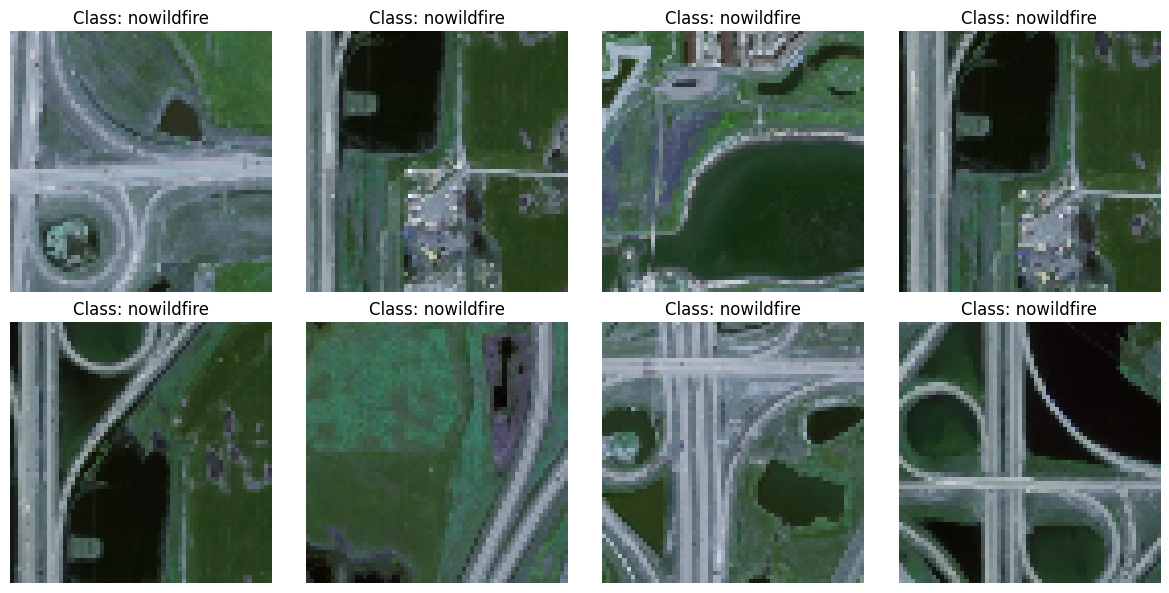

In [7]:
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(model.x_train[i])
    plt.title(f"Class: {model.class_names[model.y_train[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
autoencoder = model.build_autoencoder()

# Display model summaries
print("Encoder Model Summary:")
model.encoder.summary()
print("\nDecoder Model Summary:")
model.decoder.summary()
print("\nAutoencoder Model Summary:")
model.autoencoder.summary()


Encoder Model Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,424 (732.12 KB)

 Trainable params: 187,424 (732.12 KB)

 Non-trainable params: 0 (0.00 B)


Decoder Model Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │       135,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 64)       │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,355 (892.01 KB)

 Trainable params: 228,355 (892.01 KB)

 Non-trainable params: 0 (0.00 B)


Autoencoder Model Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       187,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 3)      │       228,355 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,779 (1.59 MB)

 Trainable params: 415,779 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
AUTOENCODER_EPOCHS = 50
AUTOENCODER_BATCH_SIZE = 32
print("Training the autoencoder...")
model.train_autoencoder(epochs=AUTOENCODER_EPOCHS, batch_size=AUTOENCODER_BATCH_SIZE)

Training the autoencoder...
Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 144s 721ms/step - loss: 0.0322 - val_loss: 0.0184
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 72s 367ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 63s 322ms/step - loss: 0.0180 - val_loss: 0.0181
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 60s 306ms/step - loss: 0.0180 - val_loss: 0.0180
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 5729s 29s/step - loss: 0.0176 - val_loss: 0.0180
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - loss: 0.0177 - val_loss: 0.0178
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 57s 292ms/step - loss: 0.0176 - val_loss: 0.0178
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 57s 288ms/step - loss: 0.0176 - val_loss: 0.0176
Epoch 9/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 52s 265ms/step - loss: 0.0178 - val_loss: 0.0176
Epoch 10/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - loss: 0.0176 - val_loss: 0.0175
Epoch 11/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 56s 285ms/step - loss: 0.0175 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step


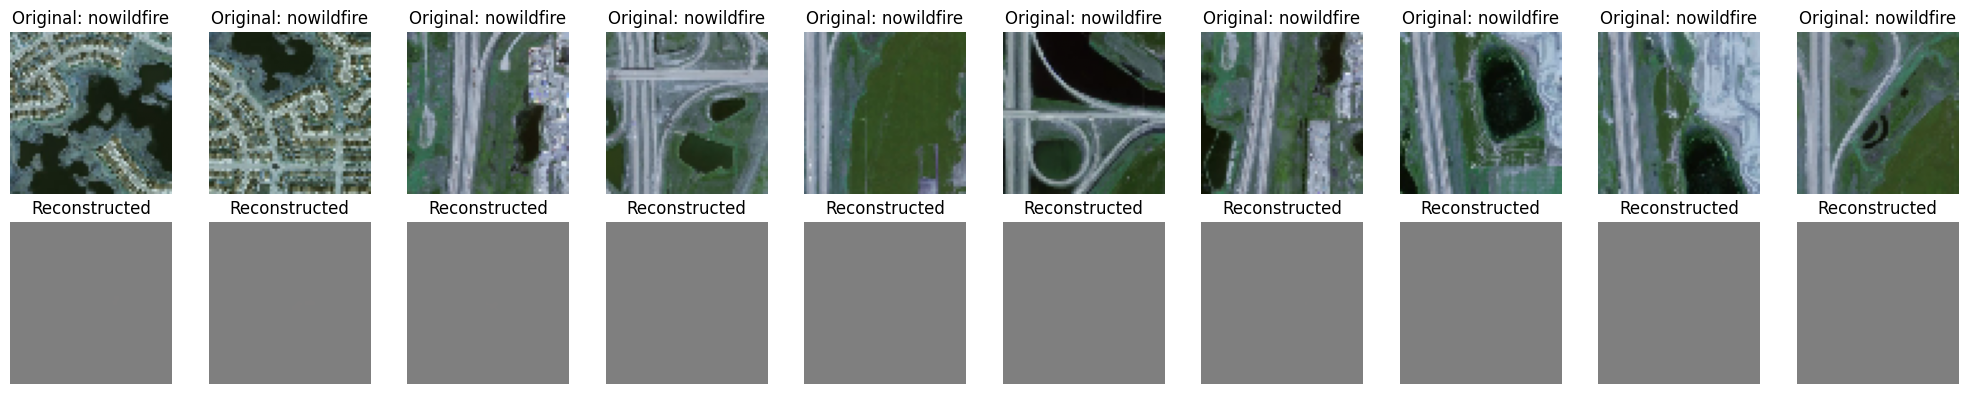

AttributeError: 'WildfireAutoencoder' object has no attribute 'autoencoder_history'

In [ ]:
# Cell 9: Evaluate autoencoder and plot training history
# Visualize original vs reconstructed images
model.evaluate_autoencoder()

# Plot training history (loss)
model.plot_training_history(model_type='autoencoder')

In [29]:
# Cell 10: Build classifier model
classifier = model.build_classifier()
print("Classifier Model Summary:")
model.classifier.summary()

Classifier Model Summary:


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       187,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 1)              │         2,177 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,601 (740.63 KB)

 Trainable params: 2,177 (8.50 KB)

 Non-trainable params: 187,424 (732.12 KB)

In [38]:
# Cell 11: Train classifier
# You can adjust these parameters
epochs = 20
batch_size = 32

# Train the classifier
model.train_classifier(epochs=epochs, batch_size=batch_size)

AttributeError: 'NoneType' object has no attribute 'fit'

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9200 - loss: 0.2061

Test Accuracy: 0.8976
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step


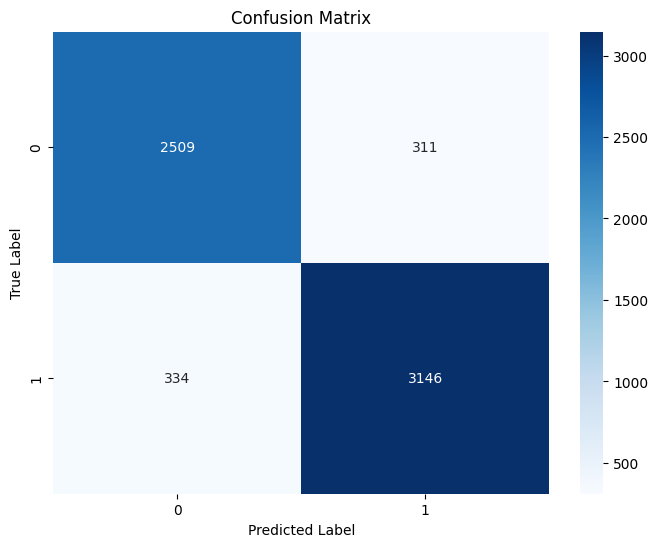


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      2820
           1       0.91      0.90      0.91      3480

    accuracy                           0.90      6300
   macro avg       0.90      0.90      0.90      6300
weighted avg       0.90      0.90      0.90      6300



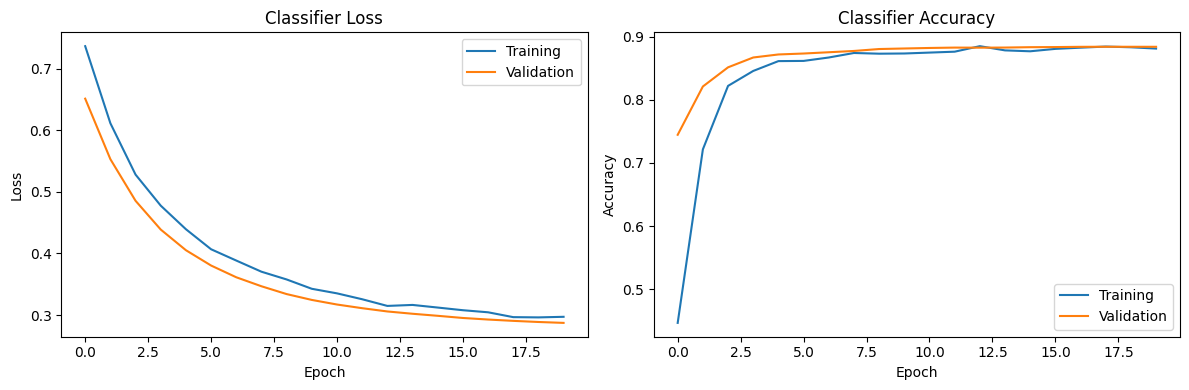

In [31]:
# Cell 12: Evaluate classifier and plot training history
# Evaluate on test set
model.evaluate_classifier()

# Plot training history (accuracy and loss)
model.plot_training_history(model_type='classifier')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


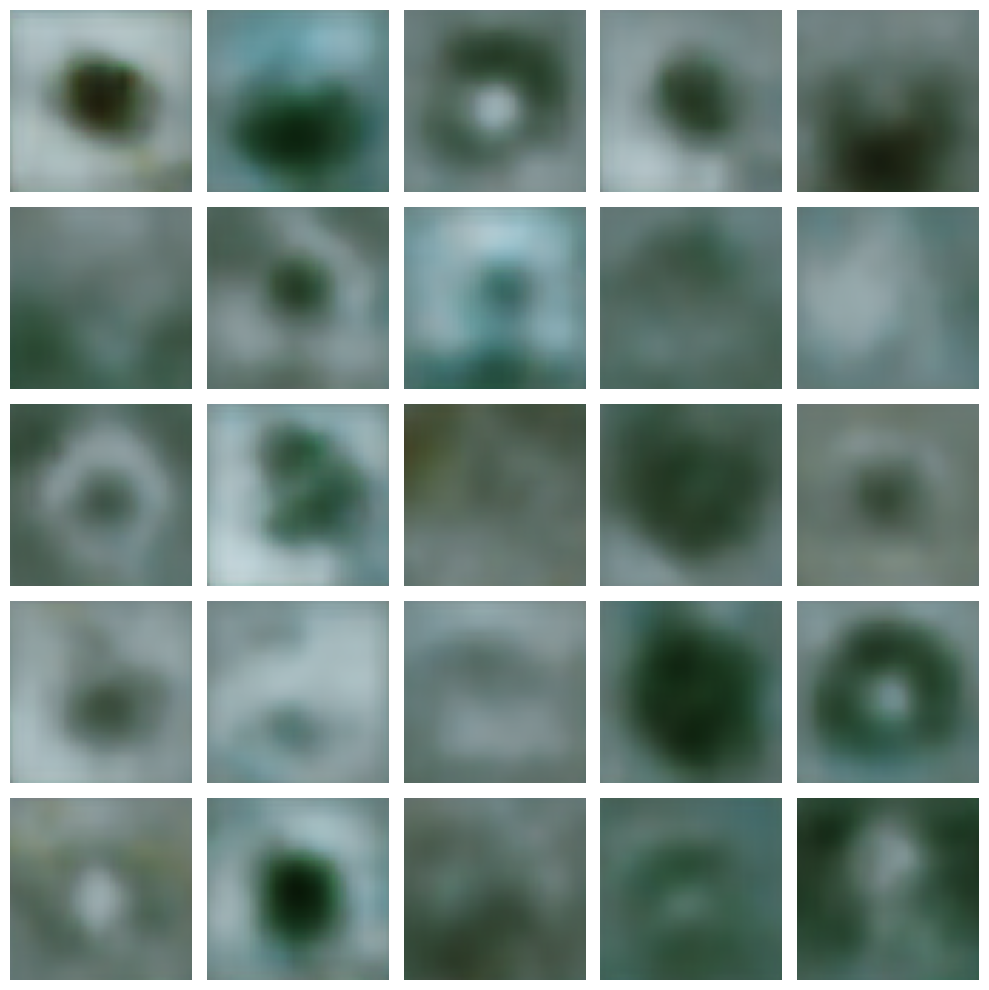

In [32]:
# Cell 13: Visualize latent space
# Generate images from random latent space points
model.plot_latent_space(n=5)  # 5x5 grid of generated images

In [33]:
# Cell 14: Save models
# Save all models to disk
models_dir = 'wildfire_models'
model.save_models(models_dir)

Models saved to wildfire_models


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Prediction: No Wildfire
Confidence: 81.11%
Reconstruction Error: 0.029788


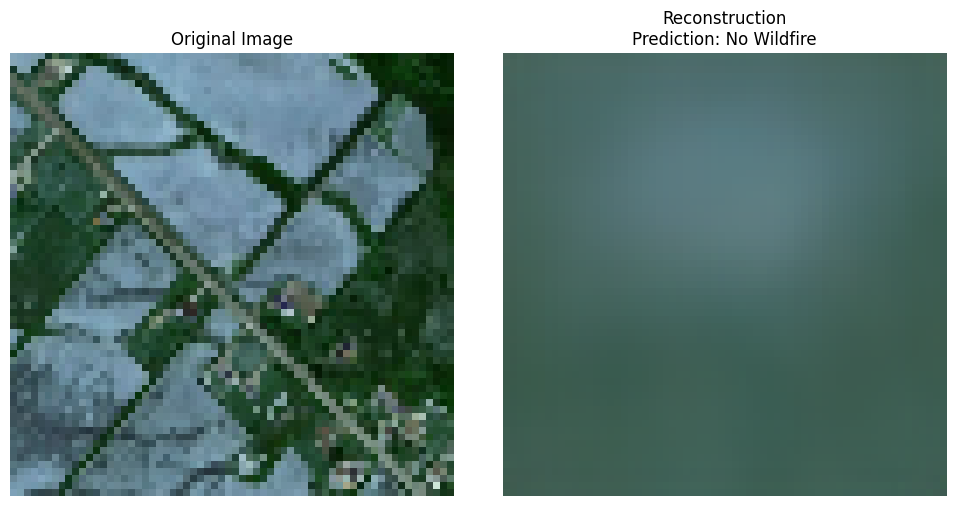

In [34]:
# Cell 15: Example - Predict on single image
# Replace with the path to your image
image_path = r'C:\BA\SEM4\EDA\ML\-79.73554,43.82621.jpg'

# Predict
result = model.predict_single_image(image_path)

# Display results
print(f"Prediction: {result['class']}")
print(f"Confidence: {result['confidence']*100:.2f}%")
print(f"Reconstruction Error: {result['reconstruction_error']:.6f}")

# Display original and reconstruction
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
original_img = cv2.imread(image_path)
original_img = cv2.resize(original_img, (model.img_size, model.img_size))
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(result['reconstruction'])
plt.title(f"Reconstruction\nPrediction: {result['class']}")
plt.axis('off')
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

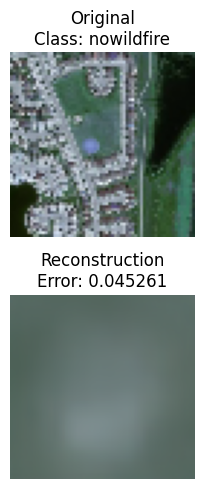

In [35]:
# Cell 16: Example - Detect anomalies
# Get a batch of test images
test_batch = model.x_test[:50]

# Detect anomalies
anomalies, threshold = model.detect_anomalies(test_batch)

# Print anomaly information
anomaly_count = sum(1 for a in anomalies if a['is_anomaly'])
print(f"Detected {anomaly_count} anomalies out of {len(test_batch)} images")
print(f"Anomaly threshold: {threshold:.6f}")

# Display some anomalies if found
if anomaly_count > 0:
    # Get indices of anomalies
    anomaly_indices = [a['index'] for a in anomalies if a['is_anomaly']]
    
    # Plot up to 4 anomalies
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(anomaly_indices[:4]):
        # Original
        plt.subplot(2, 4, i+1)
        plt.imshow(test_batch[idx])
        plt.title(f"Original\nClass: {model.class_names[model.y_test[idx]]}")
        plt.axis('off')
        
        # Reconstruction
        plt.subplot(2, 4, i+5)
        recon = model.autoencoder.predict(test_batch[idx:idx+1])[0]
        plt.imshow(recon)
        plt.title(f"Reconstruction\nError: {anomalies[idx]['reconstruction_error']:.6f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [36]:
# Cell 17: Load saved models (for later use)
# Create a new model instance
loaded_model = WildfireAutoencoder(img_size=img_size, latent_dim=latent_dim)

# Load the processed data
loaded_model.load_processed_data('preprocessed_data')

# Load the saved models
loaded_model.load_models(models_dir)

# Verify the loaded model works
test_img = loaded_model.x_test[0:1]
test_recon = loaded_model.autoencoder.predict(test_img)[0]
test_pred = loaded_model.classifier.predict(test_img)[0][0]

# Display results
print(f"Loaded model prediction: {'Wildfire' if test_pred > 0.5 else 'No Wildfire'}")
print(f"Confidence: {(test_pred if test_pred > 0.5 else 1-test_pred)*100:.2f}%")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(loaded_model.x_test[0])
plt.title(f"Original\nActual: {loaded_model.class_names[loaded_model.y_test[0]]}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(test_recon)
plt.title(f"Reconstruction\nPrediction: {'Wildfire' if test_pred > 0.5 else 'No Wildfire'}")
plt.axis('off')
plt.tight_layout()
plt.show()

Preprocessed data loaded from preprocessed_data


Encoder model loaded
Decoder model loaded


TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}